#### Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#### Create a function to read text file, clean and convert to dataframe

In [2]:
def textToDF(txtfile):
    stagelist = []
    with open(txtfile, 'r') as file:
        next(file)
        for line in file:
            line = line.replace('\n', '')
            stagelist = stagelist + [line]
    df = pd.DataFrame({'Number': stagelist})
    df[['Number','Character', "Line"]] = df['Number'].str.split('" "',expand=True)
    df['Number'] = df['Number'].str[1:] # remove fist quotation
    df['Number'] = pd.to_numeric(df['Number'], errors='coerce')
    df['Line'] = df['Line'].str[:-1] # remove last quotation
    return(df)

#### Apply function to all three text files and peek at episode 4

In [4]:
episode4 = textToDF('SW_EpisodeIV.txt')
episode5 = textToDF('SW_EpisodeV.txt')
episode6 = textToDF('SW_EpisodeVI.txt')

episode4.head()

,Number,Character,Line
0,1,THREEPIO,Did you hear that? They've shut down the main...
1,2,THREEPIO,We're doomed!
2,3,THREEPIO,There'll be no escape for the Princess this time.
3,4,THREEPIO,What's that?
4,5,THREEPIO,I should have known better than to trust the l...


#### Visualize lines by episode

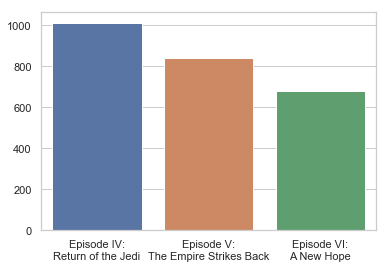

In [6]:
movies = ['Episode IV:\nReturn of the Jedi', 'Episode V:\nThe Empire Strikes Back', 'Episode VI:\nA New Hope']
line_counts = [episode4['Number'].count(), episode5['Number'].count(), episode6['Number'].count()]
sns.set(style="whitegrid")
ax = sns.barplot(x=movies, y=line_counts)

### NLP Sentiment Analysis

#### Combine Dataframes, Group by Character

In [9]:
allDF = episode4.copy()
allDF = allDF.append(episode5, ignore_index=True).append(episode6, ignore_index=True)
allDF = allDF.groupby(('Character'))
allDF = allDF['Line'].unique().to_frame().reset_index()
allDF['Line'] = allDF['Line'].apply(lambda x: ' '.join(x))
allDF['Number of Lines'] = allDF['Line'].apply(lambda x: len(x))
allDF.sort_values('Number of Lines', ascending=False).head(10)

,Character,Line,Number of Lines
61,LUKE,Hurry up! Come with me! What are you waiting...,23750
46,HAN,Han Solo. I'm captain of the Millennium Falco...,22987
111,THREEPIO,Did you hear that? They've shut down the main...,19922
8,BEN,Hello there! Come here my little friend. Don...,9963
59,LEIA,"Lord Vader, I should have known. Only you cou...",9587
116,VADER,Where are those transmissions you intercepted?...,8371
58,LANDO,"Why, you slimy, double-crossing, no-good swind...",5669
127,YODA,"Hmmm. Much anger in him, like his father. Hah....",4352
32,EMPEROR,There is a great disturbance in the Force. We ...,3573
11,BIGGS,"Just now. I wanted to surprise you, hot shot....",2814


#### Create Bag of Words for Luke and transpose

In [12]:
vec = CountVectorizer()
luke = allDF.loc[allDF['Character'] == 'LUKE']
doc = luke['Line'].to_list()
X = vec.fit_transform(doc)
luke = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
luke = luke.T.reset_index()
luke.columns = ['word', 'count']
luke.head(10)

,word,count
0,38,1
1,aaargh,1
2,about,15
3,above,2
4,academy,3
5,accelerator,1
6,accepted,1
7,across,1
8,action,1
9,actions,1


#### Use SentimentIntensity to get Sentiment for each word

In [14]:
sent = SentimentIntensityAnalyzer()
sentiments = []
for word in luke['word']:
    if sent.polarity_scores(word)['compound'] >= 0.5:
        sentiments = sentiments + ['positive']
    elif sent.polarity_scores(word)['compound'] <= -0.5:
        sentiments = sentiments + ['negative']
    else:
        sentiments = sentiments + ['neutral']
luke['sentiments'] = sentiments
luke.head(10)

,word,count,sentiments
0,38,1,neutral
1,aaargh,1,neutral
2,about,15,neutral
3,above,2,neutral
4,academy,3,neutral
5,accelerator,1,neutral
6,accepted,1,neutral
7,across,1,neutral
8,action,1,neutral
9,actions,1,neutral


#### See Counts of Sentiments for Luke

In [15]:
luke.groupby('sentiments')['count'].agg(['sum', 'count'])

,sum,count
sentiments,,
negative,43,20
neutral,4191,833
positive,36,14
